# How do the world’s biggest economies cope with the SARS-CoV2 pandemic until April 2020?

## by Robert Friebe (April 2020)

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# set up display area to show dataframe in jupyter qtconsole

pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 500)

# Questions to be answered

1. How the infestation rate does develop in the biggest economies under consideration of unreported cases? 
2. How the case-related fatality rate does develop in the biggest economies under consideration of the number of unreported cases?
3. Where do the biggest economies positioning themselves at the end of April when the case-related fatality rate is compared to the infestation rate?
4. Additional clustering using k-means considering the infestation rate and the case-related fatality rate

## Data required

- JHU-SARS-CoV-2 data
- Population by Country
- Additional: World Bank Region including Income Groups (for additional analyses)

## Resources

- World Bank Regions: https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups
- Population by Country (Up-to-dateness: 2018): https://github.com/datasets/population/tree/master/data
- JHU-SARS-CoV-2 data: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

# 1.  Data Gathering & Wrangling

## 1.1 Gathering

- Johns Hopkins University SARS-CoV2 timeseries (confirmed, recovered, deaths): The data can be downloaded directly from github, this is optional and can be done by uncommenting the "Read JHU Statistics" part
- World Bank Regions / Income Group by Country
- Population by Country

In [47]:
# JHU-SARS-CoV-2 Statistics

## Confirmed cases by day
## Recovered cases by day
## Deaths by day

## All values are cumulative

#raw_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
#raw_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
#raw_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

#confirmed.to_csv("files/confirmed.csv", index=False)
#recovered.to_csv("files/recovered.csv", index=False)
#deaths.to_csv("files/deaths.csv", index=False)


# Read local files (Up-to-dateness: May 2nd, 2020)
confirmed = pd.read_csv('files/confirmed.csv')
recovered = pd.read_csv('files/recovered.csv')
deaths = pd.read_csv('files/deaths.csv')

print("Confirmed: ", confirmed.shape)
print("Recovered: ", recovered.shape)
print("Deaths: ", deaths.shape)

Confirmed:  (266, 106)
Recovered:  (252, 106)
Deaths:  (266, 106)


In [48]:
# World Bank Regions
## Read local data
wbr = pd.read_excel("files/world_bank_region_by_income.xls", sheet_name=3)
print("Contry by World Bank Region: ", wbr.shape)

Contry by World Bank Region:  (218, 7)


In [49]:
# Read Population by Country data
# Read local data
#pop = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
pop = pd.read_csv("files/population.csv")
print("Population by Country: ", pop.shape)

Population by Country:  (15409, 4)


## 1.2 Data Wrangling

1. SARS-CoV2 Statistic
2. World Bank Regions
3. Population by Country
4. Merge datasets

### 1.2.1 SARS-CoV2 Statistics

- Build Category (Confirmed, Recovered, Deaths)
- Concatenate Confirmed, Recovered and Deaths tables
- Melt dataset (using Pandas melt function) by the variables Category, Province State, Country Region, Latitude and Logitude
- Reorder the columns of the dataframe: category, province state, country region, latitude, longitude
- Melt the dataframe with the id variables: category, province state, country region, latitude, longitude, so that the date is from wide to long format (tidy)
- transform the date into datetype

In [50]:
# Make a category column
confirmed['category'] = "confirmed"
recovered['category'] = "recovered"
deaths['category'] = "deaths"

In [51]:
# Concatenation
frames = [confirmed, recovered, deaths]
df = pd.concat(frames)
print(df.shape)

(784, 107)


In [52]:
# Reorder Columns of data frame
index = df[['category', 'Province/State', 'Country/Region', 'Lat', 'Long']]
date_values = df.drop(['category', 'Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
df2 = pd.concat([index, date_values], axis=1)

In [53]:
# Melt, all the dates into one column, the va
df3 = pd.melt(df2, id_vars = ['category', 'Province/State', 'Country/Region', 'Lat', 'Long'])

In [54]:
df3[df3['Country/Region'] == 'Germany'].tail()

,category,Province/State,Country/Region,Lat,Long,variable,value
78778,recovered,NaN,Germany,51.0,9.0,5/1/20,126900
79038,deaths,NaN,Germany,51.0,9.0,5/1/20,6736
79304,confirmed,NaN,Germany,51.0,9.0,5/2/20,164967
79562,recovered,NaN,Germany,51.0,9.0,5/2/20,129000
79822,deaths,NaN,Germany,51.0,9.0,5/2/20,6812


In [55]:
# Make date type column
df4 = df3.copy()
df4['date'] = pd.to_datetime(df4['variable'])
df4.drop(['variable'], axis=1, inplace=True)

df4[df4['Country/Region'] == 'Germany'].tail()

,category,Province/State,Country/Region,Lat,Long,value,date
78778,recovered,NaN,Germany,51.0,9.0,126900,2020-05-01
79038,deaths,NaN,Germany,51.0,9.0,6736,2020-05-01
79304,confirmed,NaN,Germany,51.0,9.0,164967,2020-05-02
79562,recovered,NaN,Germany,51.0,9.0,129000,2020-05-02
79822,deaths,NaN,Germany,51.0,9.0,6812,2020-05-02


In [56]:
df4.shape

(79968, 7)

- Before we continue to wrangle the data any further, we have to aggregate the data by Country Region
- Some contries are diffentiated by their Province States, e.g. Canada or China
- But our analysis is based on the level of Country Region
- We dont need the Latitude and Longitude any longer, since we are not going to plot the data on a map

- Source: Pandas GroupBy: Your Guide to Grouping Data in Python (https://realpython.com/pandas-groupby/)

In [57]:
df5 = df4.groupby(['category', 'Country/Region', 'date'], as_index=False)['value'].sum()
df5.shape

(57222, 4)

In [58]:
df5[df5['Country/Region'] == 'Germany'].tail()

,category,Country/Region,date,value
44977,recovered,Germany,2020-04-28,117400
44978,recovered,Germany,2020-04-29,120400
44979,recovered,Germany,2020-04-30,123500
44980,recovered,Germany,2020-05-01,126900
44981,recovered,Germany,2020-05-02,129000


In [59]:
# Removing leading and trailing white spaces in province state
df5['Country/Region'] = df5['Country/Region'].str.strip()

- Don't needed anymore, since we are not using the Province/State for analysis

In [60]:
# transpose dataset ID-Columns: country.region, date
## stackoverflow: pandas equivalent for R dcast
## https://stackoverflow.com/questions/36970264/pandas-equivalent-for-r-dcast

df6 = (df5.pivot_table(index = ["Country/Region", "date"],
                      columns = "category",
                      values = "value").reset_index())

df6[df6['Country/Region'] == 'Germany'].tail()

category,Country/Region,date,confirmed,deaths,recovered
6829,Germany,2020-04-28,159912,6314,117400
6830,Germany,2020-04-29,161539,6467,120400
6831,Germany,2020-04-30,163009,6623,123500
6832,Germany,2020-05-01,164077,6736,126900
6833,Germany,2020-05-02,164967,6812,129000


#### 1.2.1.1 Clean confirmed, deaths, recovered

#### Problem

- The columns confirmed, deaths and recovered are cumulative
- the value of the following day may not be less than that of the previous day
- As can be seen for the example of Spain, those errors must be corrected for all countries, because the calculation of the additional features depends on these measures

#### Solution 

- Create a function "cum_repair" that takes a dataset and a measure
- It will test, if the current observation of the measure is bigger than the previous observation
- If not, the current observation will take the value of the previous observation
- This will be done for the 3 measures: confirmed, recovered and deaths

In [61]:
df6[(df6['Country/Region'] == 'Spain') & (df6['date'] >= '2020-04-22') & (df6['date'] < '2020-05-02') ]

category,Country/Region,date,confirmed,deaths,recovered
16105,Spain,2020-04-22,208389,21717,85915
16106,Spain,2020-04-23,213024,22157,89250
16107,Spain,2020-04-24,202990,22524,92355
16108,Spain,2020-04-25,205905,22902,95708
16109,Spain,2020-04-26,207634,23190,98372
16110,Spain,2020-04-27,209465,23521,100875
16111,Spain,2020-04-28,210773,23822,102548
16112,Spain,2020-04-29,212917,24275,108947
16113,Spain,2020-04-30,213435,24543,112050
16114,Spain,2020-05-01,213435,24543,112050


In [62]:
# Iterate over alle Countries

# Iterate over all rows
# If previous value is bigger than actual, set previous value
# If previous value is not bigger than actual value, go on and save actual value 
def cum_repair(df, column):
    
    countries = df['Country/Region'].unique()

    for country in countries:

        # Subset dataframe
        tbl = df[df['Country/Region'] == country]

        # Initial value
        previous = int(tbl[tbl['date'] == min(tbl['date'])][column])   

        # Delete from original dataset
        df = df[df['Country/Region'] != country]

        for index, row in tbl.iterrows():
            # If value is greater or equal previous value set previous to actual value
            if tbl.loc[index, column] >= previous:
                previous = tbl.loc[index, column]
                
            # If value is smaller than previous value, update actual value with previous
            if tbl.loc[index, column] < previous:

            # Uncomment if you want to see which values are updated
             #   print(tbl.loc[index, 'Country/Region'], tbl.loc[index, 'date'],
             #        "old: ", tbl.loc[index, column], "new: ", previous)

                tbl.loc[index, column] = previous
                previous_new = tbl.loc[index, column]
                previous = previous_new

        # concatenate orginial data back with updated data
        frames = [df, tbl]
        df = pd.concat(frames)
    
    return df

In [63]:
df7 = df6.copy()

to_repair = ['confirmed', 'deaths', 'recovered']

for column in to_repair:
    df7 = cum_repair(df7, column)

In [64]:
# Inspection: Updated dataset
df7[df7['Country/Region'].isin(['Spain'])].tail(10)

category,Country/Region,date,confirmed,deaths,recovered
16106,Spain,2020-04-23,213024,22157,89250
16107,Spain,2020-04-24,213024,22524,92355
16108,Spain,2020-04-25,213024,22902,95708
16109,Spain,2020-04-26,213024,23190,98372
16110,Spain,2020-04-27,213024,23521,100875
16111,Spain,2020-04-28,213024,23822,102548
16112,Spain,2020-04-29,213024,24275,108947
16113,Spain,2020-04-30,213435,24543,112050
16114,Spain,2020-05-01,213435,24543,112050
16115,Spain,2020-05-02,216582,25100,117248


### 1.2.2 World Bank Regions

- Only consider economy, code, region, income group 

In [65]:
wbr.head(1)

,Economy,Code,X,Region,Income group,Lending category,Other
0,Afghanistan,AFG,NaN,South Asia,Low income,IDA,HIPC


In [66]:
# subset columns
wbr2 = wbr[['Code', 'Region', 'Income group', 'Economy']]
# count countries by income group
wbr2['Income group'].value_counts()
# check for duplicates
wbr2[wbr2['Code'].duplicated()]
# count countries by region
wbr['Region'].value_counts()

Europe & Central Asia         58
Sub-Saharan Africa            48
Latin America & Caribbean     42
East Asia & Pacific           38
Middle East & North Africa    21
South Asia                     8
North America                  3
Name: Region, dtype: int64

### 1.2.3 Population by Country

- Only use the latest complete population date, which is the year 2018

In [67]:
# duplicates check
pop[pop['Country Code'].duplicated()]
# Choose latest year (2018)
pop2 = pop[pop['Year'] == 2018]
pop2.shape
# subset columns
pop3 = pop2[['Country Name', 'Country Code', 'Value']]
# rename value column to population column
pop3 = pop3.rename(columns={"Value" : "Population"})
pop3[pop3["Country Name"] == "United States"]

,Country Name,Country Code,Population
14848,United States,USA,326687501


## 1.2.4 Merge World Bank Region and Population Datasets

- merge left join on country code
- check if there are missing population data
- if so, manually fill in missing values (Eritrea, Taiwan)

In [68]:
# Merge, left join on Country Code
pop_region = pd.merge(wbr2, pop3, how="left", left_on=['Code'], right_on=['Country Code'])
# duplicate check, if zero then okay
sum(pop_region.isnull().values.any(axis=1))

2

In [69]:
pop_region[pop_region['Country Name'].isnull()]

,Code,Region,Income group,Economy,Country Name,Country Code,Population
61,ERI,Sub-Saharan Africa,Low income,Eritrea,NaN,NaN,NaN
190,TWN,East Asia & Pacific,High income,"Taiwan, China",NaN,NaN,NaN


In [70]:
# Taiwan and Eritrea missing in population dataset
# manually fill in values 

pop_region2 = pop_region.copy()

# Impute: 
for i in pop_region2.index:
    if pop_region2.loc[i, 'Code'] == 'TWN':
        pop_region2.loc[i, 'Population'] = 23808886
        pop_region2.loc[i, 'Country Name'] = pop_region2.loc[i, 'Economy']
        pop_region2.loc[i, 'Country Code'] = pop_region2.loc[i, 'Code']
    if pop_region2.loc[i, 'Code'] == 'ERI':
        pop_region2.loc[i, 'Population'] = 3537059
        pop_region2.loc[i, 'Country Name'] = pop_region2.loc[i, 'Economy']
        pop_region2.loc[i, 'Country Code'] = pop_region2.loc[i, 'Code']
        


In [71]:
pop_region2[pop_region2['Code'].isin(['TWN', 'ERI'])]

,Code,Region,Income group,Economy,Country Name,Country Code,Population
61,ERI,Sub-Saharan Africa,Low income,Eritrea,Eritrea,ERI,3537059.0
190,TWN,East Asia & Pacific,High income,"Taiwan, China","Taiwan, China",TWN,23808886.0


## 1.2.5 Merge SARS-CoV2 dataset with Population_Region dataset

- Merge on Country Region
- If the Country Names in the two datasets differ, they have to be found and corrected using a dictionary
- The country names, not matching with the population_region dataset are altered

In [72]:
df8 = pd.merge(df7, pop_region2, how="left", left_on=['Country/Region'], right_on=['Economy'])

In [73]:
df8.shape

(19074, 12)

In [74]:
# Check Country/Region that didn't matched with Country Name
# Show countries in covid-19 dataset, that could not be merged, due to the fact that they're name differ
df8[df8['Population'].isnull() == True]['Country/Region'].value_counts()

Cote d'Ivoire                       102
Venezuela                           102
Congo (Kinshasa)                    102
Saint Kitts and Nevis               102
Yemen                               102
Diamond Princess                    102
Brunei                              102
MS Zaandam                          102
Holy See                            102
US                                  102
Congo (Brazzaville)                 102
Egypt                               102
Korea, South                        102
Burma                               102
Czechia                             102
Slovakia                            102
Laos                                102
Western Sahara                      102
Russia                              102
Saint Lucia                         102
Kyrgyzstan                          102
Saint Vincent and the Grenadines    102
Taiwan*                             102
Iran                                102
Syria                               102


In [75]:
# Country Data: Renaming countries according to dict in pandas (stackoverflow)
# Country/Region in covid19 data should match Country Names in World Bank Region Dataset
dic = {
      'Brunei' : 'Brunei Darussalam',
      'Cote d\'Ivoire' : 'Côte d\'Ivoire',
      'US' : 'United States',
      'Western Sahara' : '...',
      'Laos' : 'Lao PDR',
      'Syria' : 'Syrian Arab Republic',
      'Russia' : 'Russian Federation',
      'Iran' : 'Iran, Islamic Rep.', 
      'Congo (Brazzaville)' : 'Congo, Rep.',
      'Venezuela' : 'Venezuela, RB',
      'Korea, South' : 'Korea, Rep.',
      'Yemen' : 'Yemen, Rep.',
      'Brunei' : 'Brunei Darussalam',
      'Saint Vincent and the Grenadines' : 'St. Vincent and the Grenadines',
      'Egypt' : 'Egypt, Arab Rep.',
      'Saint Kitts and Nevis' : 'St. Kitts and Nevis',
      'Slovakia' : 'Slovak Republic',    
      'Congo (Kinshasa)' : 'Congo, Dem. Rep.',
      'Burma' : 'Myanmar',
      'Gambia' : 'Gambia, The',
      'Taiwan*' : 'Taiwan, China',
      'Kyrgyzstan' : 'Kyrgyz Republic',
      'Bahamas' : 'Bahamas, The',
      'Czechia' : 'Czech Republic',
      'Saint Lucia' : 'St. Lucia',
      'Sao Tome and Principe' : 'São Tomé and Principe'   
     # 'MS Zaandam' : '', # no country, ship
     #  'Diamond Princess' : '', # no country ship
     # 'Holy See' : '' # no real country
      } 

df7['Country/Region'] = df7['Country/Region'].replace(dic)

In [76]:
# Join tables again, now with altered country names in covid-19 dataset
df8 = pd.merge(df7, pop_region2, how="left", left_on=['Country/Region'], right_on=['Economy'])

In [77]:
# Check Country/Region that didn't matched with Country Name
df8[df8['Population'].isnull() == True]['Country/Region'].value_counts()

MS Zaandam          102
Diamond Princess    102
...                 102
Holy See            102
Name: Country/Region, dtype: int64

- The remaining Country names are no countries (ships: Diamond Princess, MS Zaandam; church = Holy See)
-  drop all those rows in the final dataset

In [78]:
no_country = ['Diamond Princess', 'MS Zaandam', '...', 'Holy See']
for item in no_country:
    df8.drop(df8[df8['Country/Region'] == item].index, inplace=True)
    
df8[df8['Country/Region'].isin(no_country)]

,Country/Region,date,confirmed,deaths,recovered,Code,Region,Income group,Economy,Country Name,Country Code,Population


In [79]:
df8.reset_index(drop=True, inplace=True)

In [80]:
# Check if there are missing values in any column
df8.isna().sum()

Country/Region    0
date              0
confirmed         0
deaths            0
recovered         0
Code              0
Region            0
Income group      0
Economy           0
Country Name      0
Country Code      0
Population        0
dtype: int64

# 2. Feature Engineering

## 2.1 New features

- Active Infections: confirmed cases - (deaths + recovered)
- Case Fatality Rate: confirmed deaths / confirmed cases
- Crude Mortality Rate: confirmed deaths / population
- Confirmed new: confirmed current day - confirmed previous day
- New active infections: active current day - active previous day
- New deaths
- New recovered
- Doubling time: log(2) / log((1 + (confirmed new / confirmed)))
- Confirmed cases by 100k inhabitants: confirmed / (population/100000)
- Dark number = 10 times the confirmed cases by the statistic
- Confirmed_dark: confirmed cases * 10
- Percentage infections under consideration of the dark number: (confirmed cases * 10) / population
- Case Fatality Rate considering dark number: confirmed deaths / (confirmed cases * 10)

In [81]:
final = df8.copy()

final['active'] = final['confirmed'] - final['recovered'] - final['deaths']
final['cfr'] = (final['deaths'] / final['confirmed']) * 100
final['cmr'] = (final['deaths'] / final['Population']) * 100

# Python pandas equivalent to R groupby mutate
final['confirmed_new'] = final.groupby(['Country/Region'], group_keys=False).apply(lambda g: g['confirmed'] - g['confirmed'].shift(1))
final['active_new'] = final.groupby(['Country/Region'], group_keys=False).apply(lambda g: g['active'] - g['active'].shift(1))
final['deaths_new'] = final.groupby(['Country/Region'], group_keys=False).apply(lambda g: g['deaths'] - g['deaths'].shift(1))
final['recovered_new'] = final.groupby(['Country/Region'], group_keys=False).apply(lambda g: g['recovered'] - g['recovered'].shift(1))

# Doubling time
final['v_t'] = np.round( np.log(2) / np.log(1 + (final['confirmed_new'] / final['confirmed'])) , 4)

# Confirmed by 100k inhabitants
final['confirmed_100k'] = np.round( final['confirmed'] / (final['Population']/100000), 0)

# calculate days since outbreak, more than 100 confirmed cases
## stackoverflow: pandas: conditional rolling count
## github: ENH: cumcount() for DataFrames and Series
final['days_since_outbreak'] = final[final['confirmed'] > 100].groupby('Country/Region').cumcount() + 1

# people percentage suffering from disease including dark number
final['perc_infected_dn'] = ((final['confirmed'] * 10) / final['Population']) * 100 

# Case Fatality Rate considering dark number: confirmed deaths / (confirmed cases * 10)
final['perc_cfr_dn'] = (final['deaths'] / (final['confirmed'] * 10)) * 100

# Confirmed considering dark number
final['confirmed_dn'] = final['confirmed'] * 10

In [82]:
final.shape

(18666, 25)

## 2.2 feature, imputation, missing values, infinite values to to calculations

- confirmed new, active new, deaths new, recovered new: replace with 0

- v_t: calculated as a daily v_t, if no new confirmed, than value is infite, replace infinite value using forward fill : stackoverflow: How to replace NaNs by preceding values in pandas DataFrame? stackoverflow: pandas replace zeros with previous non zero value

In [83]:
final.isna().sum() 

Country/Region             0
date                       0
confirmed                  0
deaths                     0
recovered                  0
Code                       0
Region                     0
Income group               0
Economy                    0
Country Name               0
Country Code               0
Population                 0
active                     0
cfr                     7745
cmr                        0
confirmed_new            183
active_new               183
deaths_new               183
recovered_new            183
v_t                     7751
confirmed_100k             0
days_since_outbreak    12988
perc_infected_dn           0
perc_cfr_dn             7745
confirmed_dn               0
dtype: int64

In [84]:
# doubling time
# If value is infinite, replace value with 0
# If value is 0, replace value with previous value that is not zero
# create a 5 day moving average doubling time, due to smoothen extreme values 

final['v_t_clean'] = final['v_t']
final['v_t_clean'] = final['v_t_clean'].replace([np.inf, -np.inf], 0)
final['v_t_clean'] = final['v_t_clean'].replace(to_replace=0, method="ffill")

final['v_t_clean_5ma'] = final['v_t_clean'].rolling(5).mean()

In [85]:
# replace all remaining NaN with 0
final = final.replace(np.nan, 0)
final.isna().sum() 

Country/Region         0
date                   0
confirmed              0
deaths                 0
recovered              0
Code                   0
Region                 0
Income group           0
Economy                0
Country Name           0
Country Code           0
Population             0
active                 0
cfr                    0
cmr                    0
confirmed_new          0
active_new             0
deaths_new             0
recovered_new          0
v_t                    0
confirmed_100k         0
days_since_outbreak    0
perc_infected_dn       0
perc_cfr_dn            0
confirmed_dn           0
v_t_clean              0
v_t_clean_5ma          0
dtype: int64

## 2.3 Structure of the Final Dataset for Analysis

Considers only observations, where are more than 100 confirmed cases

In [86]:
final2 = final[final['days_since_outbreak'] > 0]

index = final2[['Country/Region', 'Code', 'Region', 'Income group', 'Population', 'date', 'days_since_outbreak']]
indicators = final2[['confirmed', 'recovered', 'deaths', 'confirmed_new', 'recovered_new', 'deaths_new',
                    'active_new', 'active', 'v_t_clean_5ma', 'confirmed_100k', 'perc_infected_dn', 'perc_cfr_dn',
                    'confirmed_dn', 'cfr', 'cmr']]

final2 = pd.concat([index, indicators], axis=1)

#final2.to_csv("files/final_dataset.csv", index=False)

### Example: Canada, latest date

In [87]:
pd.melt(final2[(final2["Country/Region"] == "Canada") & (final2['date'] == final2['date'].max())].head(1))

,variable,value
0,Country/Region,Canada
1,Code,CAN
2,Region,North America
3,Income group,High income
4,Population,3.70578e+07
5,date,2020-05-02 00:00:00
6,days_since_outbreak,53
7,confirmed,57926
8,recovered,23814
9,deaths,3684


# 3. Analysis (Exploratory Timeseries-Data Analysis)

## 3.1	How the infestation rate does develop in the biggest economies under consideration of unreported cases? 

- We will select the biggest econonmies and store them into a list "biggest".
- We will then use Searborn to make a lineplot, showing the development of the infestation rate (considering the dark number, 10 times higher than confirmed cases) over time, represented as days since outbreak (day in a country, since when are more than 100 confirmed cases are reported)
- To order the economies in the legend from the economy with the highest infestation to the country with the lowest infestation, we create a TOP list, capturing the results based on the latest date (max_date)

In [88]:
# Create a list with the world's biggest economies
biggest = ['United States', 'Canada', 'China', 'India', 'Italy',
          'United Kingdom', 'France', 'Germany', 'Brazil', 'Korea, Rep.',
          'Japan']

In [89]:
# Get the latest date from the dataset
max_date = final2['date'].max()

In [90]:
# Function: Top-List
def top_lst (df, max_date, biggest_lst, indicator):
    tbl_biggest = df[df['Country/Region'].isin(biggest_lst)]
    tops = tbl_biggest[(tbl_biggest['date'] == max_date)].sort_values(by=indicator, ascending=False)
    tops_lst = tops['Country/Region']
    return tops_lst

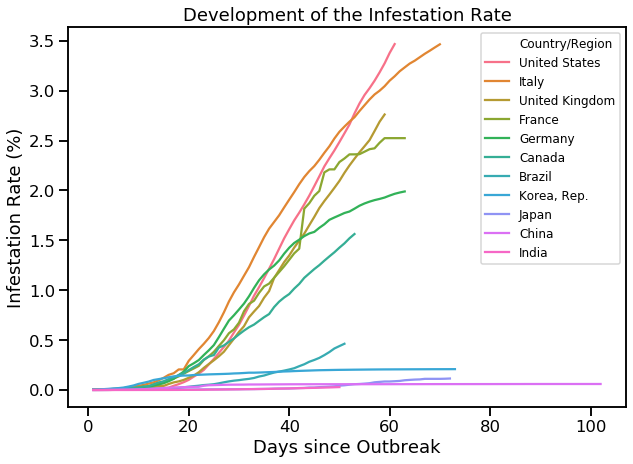

In [91]:
# Getting a list with economies in a descending order from highest to lowest by infestation
tops_lst = top_lst(final2, max_date, biggest, 'perc_infected_dn')

plt.figure(figsize=(10,7))
sns.set_context("talk")

ax = sns.lineplot(x = "days_since_outbreak", 
             y = "perc_infected_dn", 
             hue = "Country/Region", 
             hue_order = tops_lst, 
             data = final2[final2['Country/Region'].isin(biggest)])

plt.title("Development of the Infestation Rate")
plt.ylabel("Infestation Rate (%)")
plt.xlabel("Days since Outbreak")

plt.legend(fontsize=12) # using a size in points
#plt.legend(fontsize="x-large") # using a named size

plt.show()

#fig = ax.get_figure()
#fig.savefig('figures/infestation_rate.png', dpi=100)

## 3.2 How the case-related fatality rate does develop in the biggest economies under consideration of the number of unreported cases?

- Creating a lineplot using Seaborn to show the development of the case-related fatality rate, considering the number of unreported case, which is assumed to be 10 times higher than the confirmed cases shown by the statistic
- The development will be shown over the period "days since outbreak", which represent the days, from which more then 100 confirmed cases are reported by a country

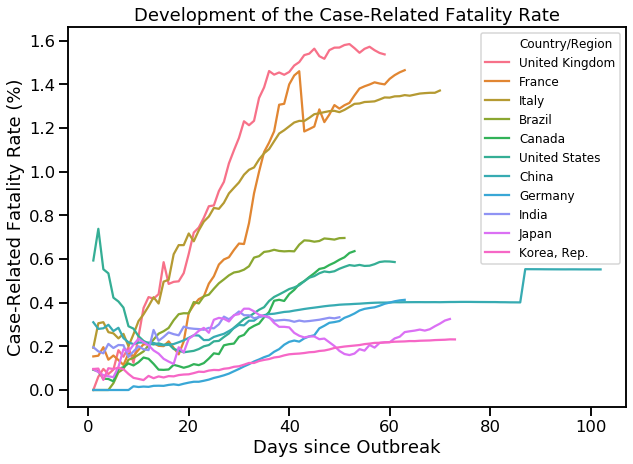

In [92]:
# Getting a list with economies in a descending order from highest to lowest by case-related fataltiy rate
tops_lst = top_lst(final2, max_date, biggest, 'perc_cfr_dn')

plt.figure(figsize=(10,7))
sns.set_context("talk")

ax = sns.lineplot(x = "days_since_outbreak", 
             y = "perc_cfr_dn", 
             hue = "Country/Region", 
             hue_order = tops_lst,
             data = final2[final2['Country/Region'].isin(biggest)])

plt.title("Development of the Case-Related Fatality Rate")
plt.ylabel("Case-Related Fatality Rate (%)")
plt.xlabel("Days since Outbreak")

plt.legend(fontsize=12) # using a size in points
#plt.legend(fontsize="x-large") # using a named size

plt.show()

#fig = ax.get_figure()
#fig.savefig('figures/case_related_fatality_rate.png', dpi=100)

## 3.3 Where do the biggest economies positioning themselves at the end of April when the case-related fatality rate is compared to the infestation rate?

- Create a scatterplot comparing infestation rate with the case-related fatality rate
- The plot shows, where the biggest economies positioning themselves a the latest date 
- The size of the dots represents the number of confirmed cases at the latest date

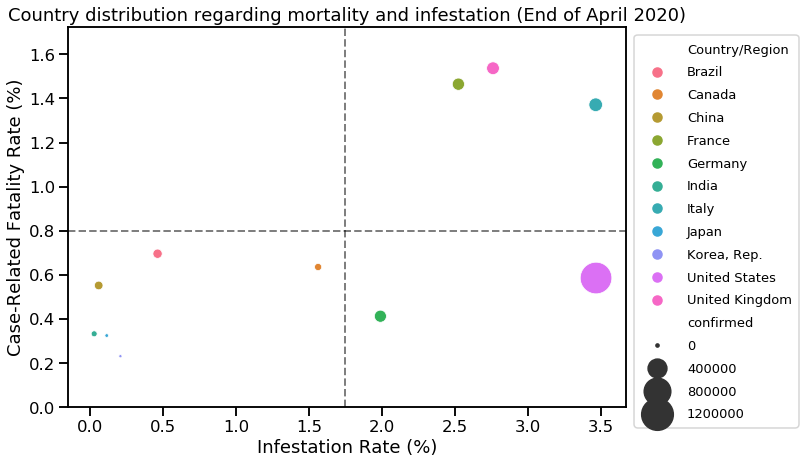

In [93]:
sns.set_context("talk")
plt.figure(figsize=(10,7))

# Create a scatterplot comparing infestation rate with the case-related fatality rate
## The plot shows, where the biggest economies positioning themselves a the latest date 
## The size of the dots represents the number of confirmed cases at the latest date
ax = sns.scatterplot(x = "perc_infected_dn", 
                y = "perc_cfr_dn", 
                hue = "Country/Region", 
                     size='confirmed', 
                     sizes = (10, 1000),
             data = final2[(final2['date'] == max_date) & 
                           (final2['confirmed_dn'] > 10000) &
                           (final2['Country/Region'].isin(biggest))])

plt.axhline(0.8, 0, 1, linewidth=2, linestyle='--', color='black', alpha=1/2)
plt.axvline(1.75, 0, 1, linewidth=2, linestyle='--', color='black', alpha=1/2)
ax.set(ylim=(0, max(final2[final2['date'] == max_date]['perc_cfr_dn']) * 1.1))
plt.legend(loc='best', framealpha=.01)
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.setp(ax.get_legend().get_texts(), fontsize='13')

plt.title("Country distribution regarding mortality and infestation (End of April 2020)")
plt.ylabel("Case-Related Fatality Rate (%)")
plt.xlabel("Infestation Rate (%)")

plt.show()

#fig = ax.get_figure()
#fig.savefig('figures/mortatlity_infestation.png', dpi=300, bbox_inches='tight')

# 4. Additional Modeling (k-Means Clustering)

- Using a k-Means clustering algorithm, fitted on the features infestation rate and case-related fatality rate
- The clustering will based on the latest date of the dataset (max_date)
- Because k-Means is using a Euclidean distance metric, whe apply a standardization to the measures (using StandardScaler)
- We us the "Elbow Method" to find the optimal number of clusters (considering WCSS (Within Cluster Sum of Squares))
- The optimal number of clusters is 5

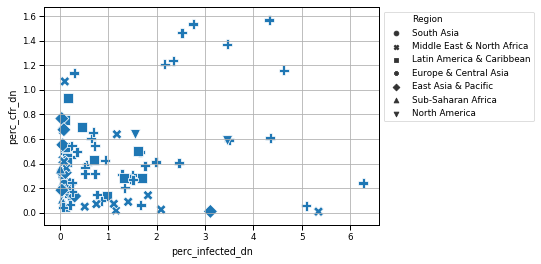

In [94]:
sns.set_context("paper")
sns.scatterplot(x = "perc_infected_dn", 
                y = "perc_cfr_dn", 
                style = "Region", 
                s=100, 
             data = final2[(final2['date'] == max_date) & (final2['confirmed_dn'] > 10000)])
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.grid()
plt.show()

In [95]:
# Create dataset
data = final2[(final2['date'] == max_date) & (final2['confirmed_dn'] > 10000)][['Country/Region', 'date', 'confirmed_dn',
                                           "Region", "Income group",
                                           'perc_infected_dn', 'perc_cfr_dn']].reset_index()

# Standardize Data: infestation rate and case-related fatality rate
X =  StandardScaler().fit_transform(data[['perc_infected_dn', 'perc_cfr_dn']])

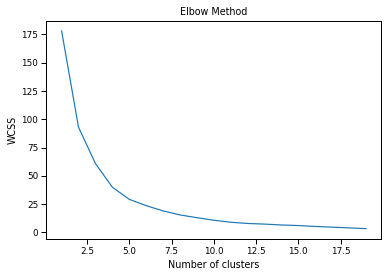

In [96]:
# Elbow Method Workflow: towards data science: K-means Clustering Python Example

wcss = []

for i in range (1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
  
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [97]:
# Fit the k-means classifier and predict cluster 
kmeans = KMeans(n_clusters=5, 
                init='k-means++', 
                max_iter=300, 
                n_init=10,
                random_state=0)
kmeans.fit(X)
predict = kmeans.predict(X)

# Join result back to the dataset
data['cluster'] = pd.Series(predict, index=data.index)

# Show a desciptive description of the clusters, using the mean of the infestation rate and case-related fatality rate
data.groupby(['cluster'])[['perc_infected_dn', 'perc_cfr_dn']].mean()

,perc_infected_dn,perc_cfr_dn
cluster,,
0,1.540297,0.253731
1,0.389831,0.689807
2,3.175048,1.363780
3,4.449441,0.299852
4,0.259622,0.236885


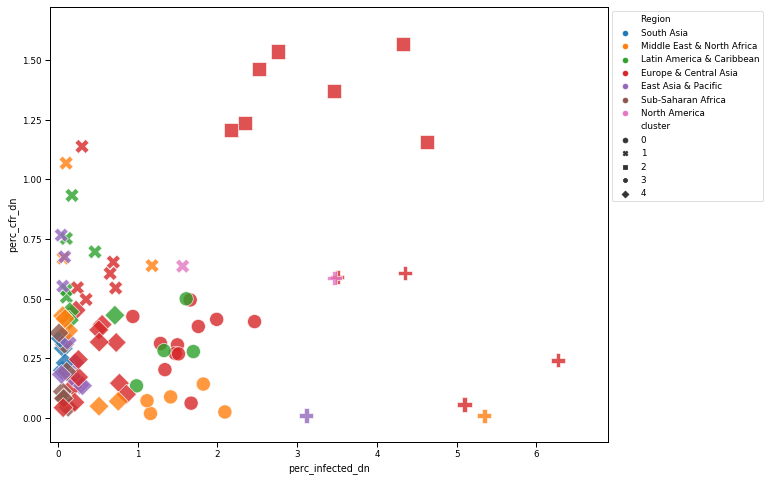

In [98]:
plt.figure(figsize=(10,8)) 
g = sns.scatterplot(x = "perc_infected_dn", 
                    y = "perc_cfr_dn",  
                    hue = "Region", 
                    style = "cluster",
                    s=200, 
                    alpha=0.8,
                    data = data)



g.set(xlim=(-.1, max(data['perc_infected_dn']*1.1)), 
      ylim=(-.1, max(data['perc_cfr_dn']*1.1)))

plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()